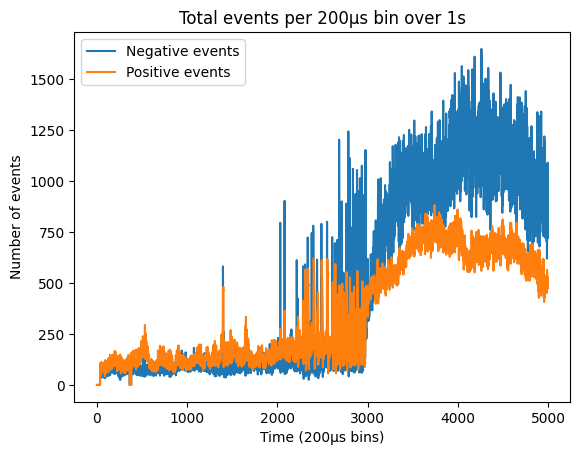

In [1]:
import numpy as np
from metavision_core.event_io import RawReader
from matplotlib import pyplot as plt
from metavision_ml.preprocessing import timesurface
from tqdm import tqdm

file = input("Enter the path to the file: ").strip()
record = RawReader(file)
height, width = record.get_size()
dt = int(1e6) # 1s in µs
events = record.load_delta_t(dt)
bins = int(dt//200) # 200µs bins
volume = np.zeros((bins, 2, int(height//4), int(width//4)))
timesurface(events, volume,dt,downsampling_factor=2, normed=True)
# Sum the timesurfaces over space
volume = np.where(volume > 0, 1, 0) # binarize the timesurfaces
volume = volume.sum(axis=(2, 3))
# flatten the timesurfaces
volume = volume.reshape(volume.shape[0], -1)
# plot the time series
plt.plot(volume)
plt.xlabel("Time (200µs bins)")
plt.ylabel("Number of events")
plt.title("Total events per 200µs bin over 1s")
plt.legend(["Negative events", "Positive events"])
plt.show()


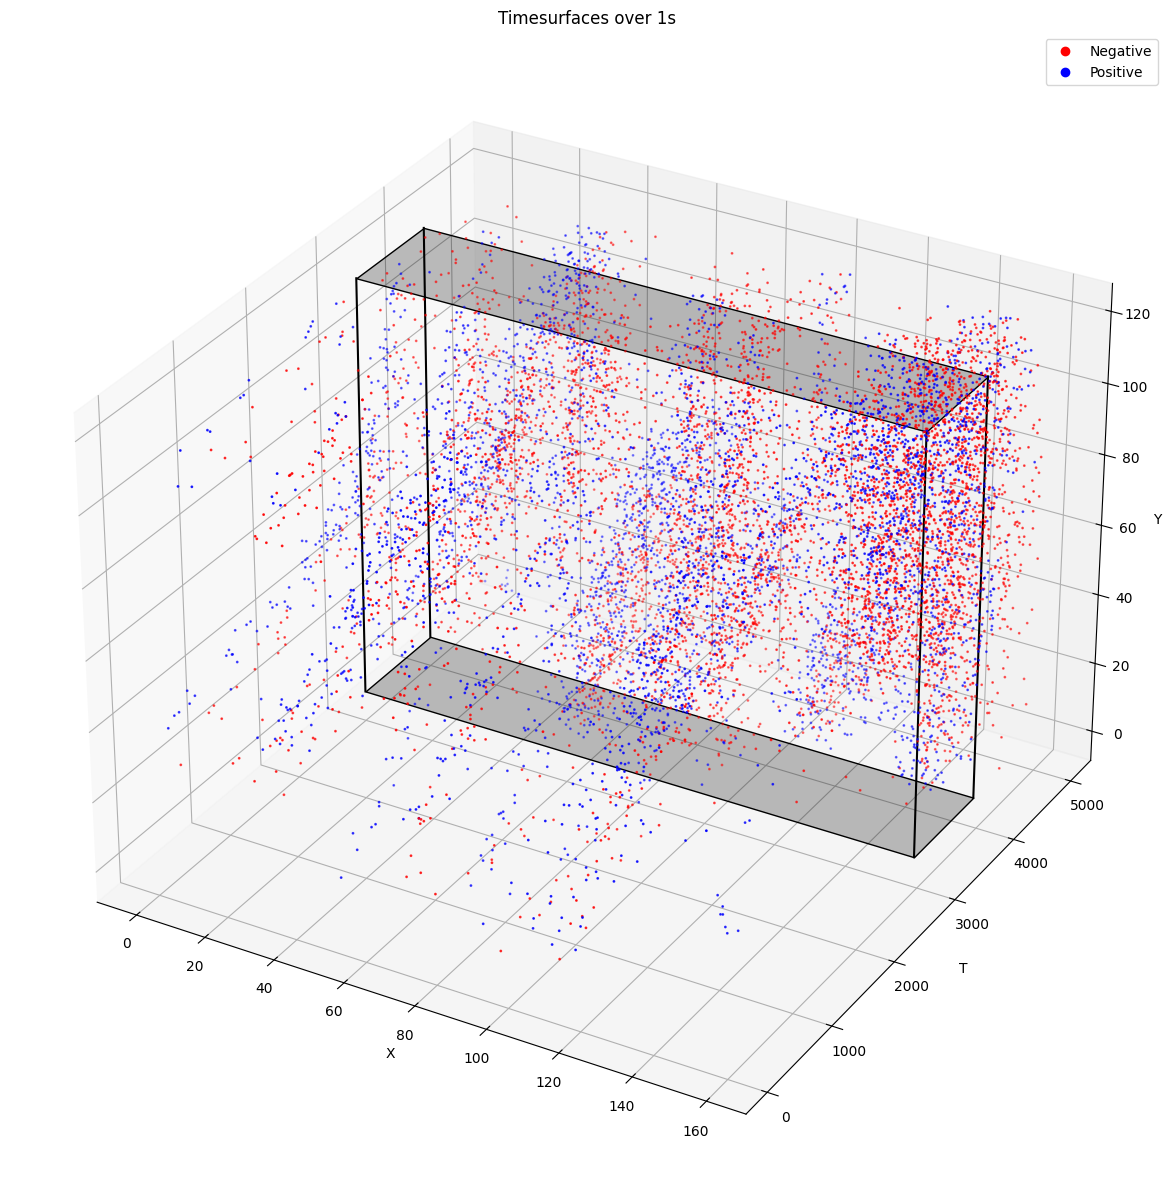

In [2]:
import pandas as pd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

volume = np.zeros((bins, 2, int(height//4), int(width//4)))
timesurface(events, volume,dt,downsampling_factor=2, normed=True)
# Prepare data for Holoviews
indices = np.argwhere(volume)
data = {'T': indices[:, 0], 'X': indices[:, 3], 'Y': indices[:, 2], 'P': indices[:, 1]}
data = pd.DataFrame(data)
del volume, indices

# Filter data to reduce size
data_sampled = data.sample(n=10000)

# Create Matplotlib figure and axis
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
colors = data_sampled['P'].map({0: 'red', 1: 'blue'})
scatter = ax.scatter(data_sampled['X'], data_sampled['T'], data_sampled['Y'], c=colors, s=1, label=['Negative', 'Positive'])

# Define the vertices of the rectangular prism
width = data['X'].max()
height = data['Y'].max()
prism_data = [
    [(0, 3000, 0), (width, 3000, 0), (width, 4000, 0), (0, 4000, 0)],  # Base
    [(0, 3000, height), (width, 3000, height), (width, 4000, height), (0, 4000, height)]  # Top
]

# Create the rectangular prism
for base in prism_data:
    verts = [base]
    ax.add_collection3d(Poly3DCollection(verts, color='black', alpha=0.25))

# Connect base and top vertices
edges = [
    ((0, 3000, 0), (0, 3000, height)),
    ((width, 3000, 0), (width, 3000, height)),
    ((width, 4000, 0), (width, 4000, height)),
    ((0, 4000, 0), (0, 4000, height))
]

for edge in edges:
    ax.plot(*zip(*edge), color='black')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('T')
ax.set_zlabel('Y')
ax.set_title('Timesurfaces over 1s')

# Legend
scatter_legend = [plt.Line2D([0], [0], linestyle='none', marker='o', color='red', label='Negative'),
                  plt.Line2D([0], [0], linestyle='none', marker='o', color='blue', label='Positive')]
ax.legend(handles=scatter_legend)

# Show plot
plt.show()

# Save plot
fig.savefig('timesurfaces_3d.png', dpi=300)# Create Holoviews Points3D element